In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import time
import optuna
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from pytorch_tabnet.tab_model import TabNetClassifier
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Data Loading

In [2]:
df_train = pd.read_csv('..\\Dataset\\raw\\train.csv')
df_test = pd.read_csv('..\\Dataset\\raw\\test.csv')

In [3]:
label = df_train.pop('outcome')

# EDA

In [4]:
df_train.head(10)

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,distend_small,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,distend_large,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,distend_small,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,normal,47.0,7.3,cloudy,2.6,no,0,0,0,yes
5,5,no,adult,529642,38.1,56.0,32.0,normal,normal,bright_pink,...,firm,49.0,8.0,cloudy,2.8,no,0,0,0,yes
6,6,yes,adult,534787,38.3,36.0,16.0,cool,reduced,normal_pink,...,NaN,43.0,75.0,cloudy,1.0,no,3111,0,0,yes
7,7,no,adult,529461,39.2,114.0,24.0,cool,reduced,pale_cyanotic,...,distend_small,57.0,7.6,serosanguious,4.5,yes,2207,0,0,yes
8,8,no,adult,528742,37.4,48.0,12.0,cool,reduced,normal_pink,...,firm,40.0,7.8,cloudy,2.6,no,0,0,0,yes
9,9,yes,adult,529640,38.3,129.0,48.0,cool,reduced,pale_pink,...,NaN,57.0,4.9,cloudy,2.9,yes,3209,0,0,yes


In [5]:
df_train.shape

(1235, 28)

In [5]:
df_train.isna().sum()

id                         0
surgery                    0
age                        0
hospital_number            0
rectal_temp                0
pulse                      0
respiratory_rate           0
temp_of_extremities       39
peripheral_pulse          60
mucous_membrane           21
capillary_refill_time      6
pain                      44
peristalsis               20
abdominal_distention      23
nasogastric_tube          80
nasogastric_reflux        21
nasogastric_reflux_ph      0
rectal_exam_feces        190
abdomen                  213
packed_cell_volume         0
total_protein              0
abdomo_appearance         48
abdomo_protein             0
surgical_lesion            0
lesion_1                   0
lesion_2                   0
lesion_3                   0
cp_data                    0
outcome                    0
dtype: int64

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   int64  
 1   surgery                1235 non-null   object 
 2   age                    1235 non-null   object 
 3   hospital_number        1235 non-null   int64  
 4   rectal_temp            1235 non-null   float64
 5   pulse                  1235 non-null   float64
 6   respiratory_rate       1235 non-null   float64
 7   temp_of_extremities    1196 non-null   object 
 8   peripheral_pulse       1175 non-null   object 
 9   mucous_membrane        1214 non-null   object 
 10  capillary_refill_time  1229 non-null   object 
 11  pain                   1191 non-null   object 
 12  peristalsis            1215 non-null   object 
 13  abdominal_distention   1212 non-null   object 
 14  nasogastric_tube       1155 non-null   object 
 15  naso

In [7]:
df_train['outcome'].unique()

array(['died', 'euthanized', 'lived'], dtype=object)

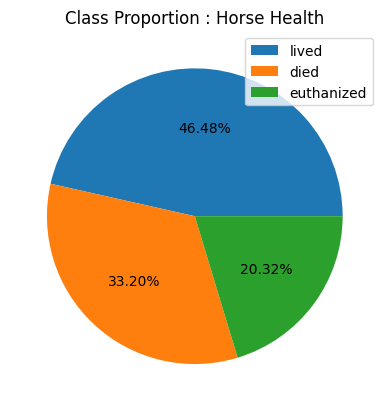

In [9]:
# Count frequency each class
category_counts = label.value_counts()
size = label.value_counts()

# Create Bar Chart
plt.pie(size, autopct="%.2f%%")
plt.legend(labels=category_counts.index)
plt.title('Class Proportion : Horse Health')
plt.show()

# Preprocessing

In [8]:
# Determine the Categorical Columns
cat_cols_dropped = ['age',
 'mucous_membrane',
 'capillary_refill_time',
 'peristalsis',
 'nasogastric_tube',
 'nasogastric_reflux',
 'rectal_exam_feces',
 'abdomen',
 'abdomo_appearance',
 'surgical_lesion']

In [9]:
# Determine the Numerical Columns
num_cols_dropped = [
 'hospital_number',
 'rectal_temp',
 'pulse',
 'respiratory_rate',
 'nasogastric_reflux_ph',
 'packed_cell_volume',
 'total_protein',
 'abdomo_protein',
 'lesion_1',
 'lesion_2']

In [10]:
def prepo(df):
    df_processed = df.copy()

    # Define Scaler
    numeric_transformer = StandardScaler()

    # Define pipeline
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(sparse_output=False))
    ])

    # Combine both encoder & scaler with ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols_dropped),
            ('cat', categorical_transformer, cat_cols_dropped)
        ])
    
    # Map the label
    label_map = {
        'died' : 0, 
        'euthanized' : 1, 
        'lived' : 2
    }
    df_processed['outcome'] = df_processed['outcome'].map(label_map)
    
    # Split data into features & label
    X = df_processed.drop(columns='outcome')
    y = df_processed['outcome']

    # Transform the feature data
    X = preprocessor.fit_transform(X)

    # split data into train & test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # change to array
    X_train = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
    X_test = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test
    y_train = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train
    y_test = y_test.to_numpy() if isinstance(y_test, pd.Series) else y_test

    return X_train, X_test, y_train, y_test


In [11]:
X_train, X_test, y_train, y_test = prepo(df_train)

In [12]:
X_train.shape

(988, 48)

In [13]:
# Determine the input and output dimensions
X_dim = X_train.shape[1]
y_dim = df_train['outcome'].nunique()

# Modelling

In [14]:
# Dataframe for evaluation result each model
eval_columns = ['Model', 'Accuracy', 'F1', 'Execution Time']
eval_results = pd.DataFrame(columns=eval_columns)
eval_results

,Model,Accuracy,F1,Execution Time


## Deep Learning

### NODE : Neural Oblivious Decision Ensembles

In [15]:
class DeepObliviousDecisionTreeLayer(nn.Module):
    def __init__(self, input_dim, num_trees, tree_depth, hidden_dim):
        super(DeepObliviousDecisionTreeLayer, self).__init__()
        self.num_trees = num_trees
        self.tree_depth = tree_depth
        self.hidden_dim = hidden_dim
        
        # Define a deeper architecture with hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(tree_depth):
            self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
            input_dim = hidden_dim 
        
        self.output_layer = nn.Linear(hidden_dim, num_trees)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = F.relu(layer(x)) 
        
        # Apply the output layer
        out = torch.sigmoid(self.output_layer(x))
        return out

class NODE(nn.Module):
    def __init__(self, input_dim, output_dim, num_trees, tree_depth, hidden_dim):
        super(NODE, self).__init__()
        self.tree_layer = DeepObliviousDecisionTreeLayer(input_dim, num_trees=num_trees, tree_depth=tree_depth, hidden_dim=hidden_dim)
        
        # Additional fully connected layers to make it deeper
        self.fc1 = nn.Linear(num_trees, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.tree_layer(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
def train_and_evaluate_model(model, model_name, X_train, X_test, y_train, y_test, num_epochs=100, learning_rate=0.001):
    # Define start time recording
    start_time = time.time()

    # Convert data to tensors
    X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
    X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)
    
    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    def eval_model(model, X, y):
        model.eval()
        with torch.no_grad():
            outputs = model(X)
            y_prob = F.softmax(outputs, dim=1)
        
        y_true = y.numpy()
        y_pred = torch.argmax(y_prob, dim=1).numpy()
        y_prob = y_prob.numpy()

        # Compute accuracy and F1 score
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')

        return accuracy, f1

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print information every 10 epochs
        if (epoch + 1) % 10 == 0 or (epoch + 1) == num_epochs:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Final evaluation at the end of training
    print('Final Evaluation:')
    final_train_accuracy, final_train_f1= eval_model(model, X_train, y_train)
    final_test_accuracy, final_test_f1= eval_model(model, X_test, y_test)

    print(f'Final Train Accuracy: {final_train_accuracy:.4f}')
    print(f'Final Train F1 Score: {final_train_f1:.4f}')
    print(f'Final Test Accuracy: {final_test_accuracy:.4f}')
    print(f'Final Test F1 Score: {final_test_f1:.4f}')
    
    # Define end time recording
    end_time = time.time()
    # Calculate the execution time
    execution_time = end_time - start_time

    result = pd.DataFrame([{'Model':model_name, 'Accuracy':final_test_accuracy, 'F1':final_test_f1, 'Execution Time':execution_time}])

    return result

In [17]:
def train_eval_non_scratch(model, model_name, X_train, X_test, y_train, y_test):
    # Define start time recording
    start_time = time.time()
    # Train
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_test)
    # Eval
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"F1: {f1:.4f}")
    # Define end time recording
    end_time = time.time()
    # Calculate the execution time
    execution_time = end_time - start_time

    result = pd.DataFrame([{'Model':model_name, 'Accuracy':accuracy, 'F1':f1, 'Execution Time':execution_time}])

    return result

In [18]:
input_dim = X_dim
output_dim = y_dim
NODE_model = NODE(input_dim, output_dim, num_trees=10, tree_depth=6, hidden_dim=128)

In [19]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

In [20]:
result = train_and_evaluate_model(NODE_model, "NODE Classifier", X_train_t, X_test_t, y_train_t, y_test_t)
eval_results = pd.concat([result, eval_results], ignore_index=True)

C:\Users\fadhil\AppData\Local\Temp\ipykernel_25476\3282095067.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
C:\Users\fadhil\AppData\Local\Temp\ipykernel_25476\3282095067.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)


Epoch [10/100], Loss: 1.0464
Epoch [20/100], Loss: 1.0391
Epoch [30/100], Loss: 0.9768
Epoch [40/100], Loss: 0.9012
Epoch [50/100], Loss: 0.8686
Epoch [60/100], Loss: 0.8415
Epoch [70/100], Loss: 0.8415
Epoch [80/100], Loss: 0.8177
Epoch [90/100], Loss: 0.8042
Epoch [100/100], Loss: 0.7976
Final Evaluation:
Final Train Accuracy: 0.6336
Final Train F1 Score: 0.5768
Final Test Accuracy: 0.5506
Final Test F1 Score: 0.5001


C:\Users\fadhil\AppData\Local\Temp\ipykernel_25476\1212388360.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_results = pd.concat([result, eval_results], ignore_index=True)


In [21]:
eval_results

,Model,Accuracy,F1,Execution Time
0,NODE Classifier,0.550607,0.500122,2.651398


### Tab Transformer

In [22]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion),
            nn.ReLU(),
            nn.Linear(forward_expansion, embed_size)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x is expected to have shape [batch_size, sequence_length, embed_size]
        attention = self.attention(x, x, x)[0]
        x = self.dropout(self.norm1(attention + x))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

class TabularTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, embed_size, num_heads, forward_expansion, dropout):
        super(TabularTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_size)
        self.transformer_block = TransformerBlock(
            embed_size=embed_size,
            heads=num_heads,
            dropout=dropout,
            forward_expansion=forward_expansion
        )
        self.fc = nn.Linear(embed_size, output_dim)

    def forward(self, x):
        # Add sequence dimension
        x = x.unsqueeze(1)
        x = self.embedding(x)
        x = self.transformer_block(x)
        x = x.squeeze(1)
        out = self.fc(x)
        return out

In [23]:
# Define Tab-Transfomer Model
TabTR_model = TabularTransformer(
    input_dim=input_dim,
    output_dim=output_dim,
    embed_size=32,
    num_heads=4,
    forward_expansion=128,
    dropout=0.1
)

In [24]:
result = train_and_evaluate_model(TabTR_model, "Tab-Transformer", X_train_t, X_test_t, y_train_t, y_test_t)
eval_results = pd.concat([result, eval_results], ignore_index=True)

C:\Users\fadhil\AppData\Local\Temp\ipykernel_25476\3282095067.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
C:\Users\fadhil\AppData\Local\Temp\ipykernel_25476\3282095067.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)


Epoch [10/100], Loss: 0.9680
Epoch [20/100], Loss: 0.8395
Epoch [30/100], Loss: 0.7982
Epoch [40/100], Loss: 0.7727
Epoch [50/100], Loss: 0.7500
Epoch [60/100], Loss: 0.7304
Epoch [70/100], Loss: 0.7130
Epoch [80/100], Loss: 0.6981
Epoch [90/100], Loss: 0.6868
Epoch [100/100], Loss: 0.6647
Final Evaluation:
Final Train Accuracy: 0.7409
Final Train F1 Score: 0.7394
Final Test Accuracy: 0.6599
Final Test F1 Score: 0.6576


### TabNet

In [25]:
# Define TabNet Model
TabNet_model = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                         optimizer_params=dict(lr=2e-2),
                         scheduler_fn=torch.optim.lr_scheduler.StepLR,
                         scheduler_params=dict(step_size=10, gamma=0.9),
                         mask_type='sparsemax')

# Train TabNet_model
TabNet_model.fit(X_train=X_train, 
          y_train=y_train, 
          eval_set=[(X_test, y_test)],
          eval_metric=['accuracy'],
          max_epochs=100, 
          patience=10,
          batch_size=256,
          virtual_batch_size=128,
          num_workers=0,
          drop_last=False)

result = train_eval_non_scratch(TabNet_model, "Tabnet", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

epoch 0  | loss: 1.65833 | val_0_accuracy: 0.46559 |  0:00:00s


c:\Users\fadhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 1.23552 | val_0_accuracy: 0.42105 |  0:00:00s
epoch 2  | loss: 1.08877 | val_0_accuracy: 0.40891 |  0:00:00s
epoch 3  | loss: 0.99626 | val_0_accuracy: 0.40891 |  0:00:00s
epoch 4  | loss: 0.93903 | val_0_accuracy: 0.4251  |  0:00:00s
epoch 5  | loss: 0.92592 | val_0_accuracy: 0.46559 |  0:00:00s
epoch 6  | loss: 0.90256 | val_0_accuracy: 0.46964 |  0:00:00s
epoch 7  | loss: 0.87455 | val_0_accuracy: 0.4413  |  0:00:00s
epoch 8  | loss: 0.85767 | val_0_accuracy: 0.57895 |  0:00:00s
epoch 9  | loss: 0.84106 | val_0_accuracy: 0.5749  |  0:00:01s
epoch 10 | loss: 0.86472 | val_0_accuracy: 0.59109 |  0:00:01s
epoch 11 | loss: 0.84272 | val_0_accuracy: 0.58704 |  0:00:01s
epoch 12 | loss: 0.83224 | val_0_accuracy: 0.62753 |  0:00:01s
epoch 13 | loss: 0.82462 | val_0_accuracy: 0.61538 |  0:00:01s
epoch 14 | loss: 0.82177 | val_0_accuracy: 0.583   |  0:00:01s
epoch 15 | loss: 0.82056 | val_0_accuracy: 0.59514 |  0:00:01s
epoch 16 | loss: 0.8143  | val_0_accuracy: 0.60729 |  0

c:\Users\fadhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\fadhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


In [26]:
eval_results

,Model,Accuracy,F1,Execution Time
0,Tabnet,0.392713,0.336341,0.094369
1,Tab-Transformer,0.659919,0.657595,2.636209
2,NODE Classifier,0.550607,0.500122,2.651398


### SAINT

In [27]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim, attn_dim, num_heads, dropout=0.1):
        super(SelfAttention, self).__init__()
        self.num_heads = num_heads
        self.attn_dim = attn_dim
        
        self.query = nn.Linear(input_dim, attn_dim * num_heads)
        self.key = nn.Linear(input_dim, attn_dim * num_heads)
        self.value = nn.Linear(input_dim, attn_dim * num_heads)
        
        self.attn_dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(attn_dim * num_heads, input_dim)
        
    def forward(self, x):
        if len(x.size()) == 2:  # If input has 2 dimensions
            x = x.unsqueeze(1)  # Add a sequence dimension: [batch_size, 1, input_dim]

        batch_size, seq_len, _ = x.size()
        
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        Q = Q.view(batch_size, seq_len, self.num_heads, self.attn_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.attn_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.attn_dim).transpose(1, 2)

        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.attn_dim ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)
        attn_output = torch.matmul(attn_weights, V)

        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        output = self.output_layer(attn_output)

        return output

class IntersampleAttention(nn.Module):
    def __init__(self, input_dim, attn_dim, num_heads, dropout=0.1):
        super(IntersampleAttention, self).__init__()
        self.num_heads = num_heads
        self.attn_dim = attn_dim
        
        self.query = nn.Linear(input_dim, attn_dim * num_heads)
        self.key = nn.Linear(input_dim, attn_dim * num_heads)
        self.value = nn.Linear(input_dim, attn_dim * num_heads)
        
        self.attn_dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(attn_dim * num_heads, input_dim)
        
    def forward(self, x):
        if len(x.size()) == 2:  # If input has 2 dimensions
            x = x.unsqueeze(1)  # Add a sequence dimension: [batch_size, 1, input_dim]

        batch_size, seq_len, _ = x.size()
        
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        Q = Q.view(batch_size, seq_len, self.num_heads, self.attn_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.attn_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.attn_dim).transpose(1, 2)

        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.attn_dim ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)
        attn_output = torch.matmul(attn_weights, V)

        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        output = self.output_layer(attn_output)

        return output

class SAINT(nn.Module):
    def __init__(self, input_dim, output_dim, attn_dim, num_heads, num_layers, hidden_dim, dropout=0.1):
        super(SAINT, self).__init__()
        
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        
        self.self_attn_layers = nn.ModuleList([
            SelfAttention(hidden_dim, attn_dim, num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        
        self.intersample_attn_layers = nn.ModuleList([
            IntersampleAttention(hidden_dim, attn_dim, num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.input_layer(x))
        
        for self_attn, intersample_attn in zip(self.self_attn_layers, self.intersample_attn_layers):
            x = self_attn(x)
            x = intersample_attn(x)
        
        x = torch.mean(x, dim=1)  # Global average pooling
        
        output = self.output_layer(x)
        
        return output

In [28]:
SAINT_model = SAINT(
    input_dim = X_dim,
    output_dim = y_dim,
    attn_dim = 16,
    num_heads = 2,
    num_layers = 3,
    hidden_dim = 64
)

In [29]:
result = train_and_evaluate_model(SAINT_model, "SAINT", X_train_t, X_test_t, y_train_t, y_test_t)
eval_results = pd.concat([result, eval_results], ignore_index=True)

C:\Users\fadhil\AppData\Local\Temp\ipykernel_25476\3282095067.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
C:\Users\fadhil\AppData\Local\Temp\ipykernel_25476\3282095067.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)


Epoch [10/100], Loss: 1.0456
Epoch [20/100], Loss: 1.0241
Epoch [30/100], Loss: 0.9651
Epoch [40/100], Loss: 0.9432
Epoch [50/100], Loss: 0.9057
Epoch [60/100], Loss: 0.8084
Epoch [70/100], Loss: 0.7892
Epoch [80/100], Loss: 0.7501
Epoch [90/100], Loss: 0.6776
Epoch [100/100], Loss: 0.6584
Final Evaluation:
Final Train Accuracy: 0.7713
Final Train F1 Score: 0.7687
Final Test Accuracy: 0.6437
Final Test F1 Score: 0.6406


## Machine Learning

### Random Forest

In [30]:
# Define Random Forest Model
rf_model = RandomForestClassifier(random_state=42)

# Train & Eval with function
result = train_eval_non_scratch(rf_model, "Random Forest", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

Accuracy: 0.6923
F1: 0.6918


### XGBoost

In [31]:
# Define XGBoost Model
xgb_model = XGBClassifier(random_state=42)

# Train & Eval with function
result = train_eval_non_scratch(xgb_model, "XGBoost", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

Accuracy: 0.6761
F1: 0.6751


### LightGBM

In [32]:
# Define LightGBM Model
lgbm_model = LGBMClassifier(random_state=42)

# Train & Eval with function
result = train_eval_non_scratch(lgbm_model, "LightGBM", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 988, number of used features: 43
[LightGBM] [Info] Start training from score -1.072637
[LightGBM] [Info] Start training from score -1.612479
[LightGBM] [Info] Start training from score -0.779791
Accuracy: 0.6964
F1: 0.6971


### CatBoost

In [33]:
# Define CatBoost Model
cb_model = CatBoostClassifier(random_state=42)

# Train & Eval with function
result = train_eval_non_scratch(cb_model, "CatBoost", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

Learning rate set to 0.079078
0:	learn: 1.0614430	total: 101ms	remaining: 1m 40s
1:	learn: 1.0330034	total: 104ms	remaining: 52s
2:	learn: 1.0023045	total: 108ms	remaining: 35.9s
3:	learn: 0.9769114	total: 111ms	remaining: 27.7s
4:	learn: 0.9517173	total: 113ms	remaining: 22.6s
5:	learn: 0.9325015	total: 116ms	remaining: 19.2s
6:	learn: 0.9133757	total: 118ms	remaining: 16.7s
7:	learn: 0.8957767	total: 120ms	remaining: 14.9s
8:	learn: 0.8790288	total: 123ms	remaining: 13.5s
9:	learn: 0.8645038	total: 125ms	remaining: 12.4s
10:	learn: 0.8506626	total: 127ms	remaining: 11.4s
11:	learn: 0.8375293	total: 130ms	remaining: 10.7s
12:	learn: 0.8246262	total: 131ms	remaining: 9.97s
13:	learn: 0.8127419	total: 133ms	remaining: 9.38s
14:	learn: 0.8019380	total: 136ms	remaining: 8.93s
15:	learn: 0.7923261	total: 138ms	remaining: 8.47s
16:	learn: 0.7835030	total: 140ms	remaining: 8.08s
17:	learn: 0.7754123	total: 142ms	remaining: 7.77s
18:	learn: 0.7677639	total: 144ms	remaining: 7.45s
19:	learn: 0

# Evaluation

In [34]:
eval_results

,Model,Accuracy,F1,Execution Time
0,CatBoost,0.708502,0.708502,2.240954
1,LightGBM,0.696356,0.697107,0.249462
2,XGBoost,0.676113,0.675060,0.486738
3,Random Forest,0.692308,0.691831,0.183719
4,SAINT,0.643725,0.640612,2.193225
5,Tabnet,0.392713,0.336341,0.094369
6,Tab-Transformer,0.659919,0.657595,2.636209
7,NODE Classifier,0.550607,0.500122,2.651398


In [35]:
# eval_results.to_excel('HorseHealth_Eval_Results.xlsx', index=False)